# Redes LSTM

Nesta aula, vamos aprender sobre Redes Neurais Recorrentes (RNNs) e, em particular, sobre a Long Short-Term Memory (LSTM). Vamos abordar:

- O que são redes LSTM e por que são úteis.
- Como implementá-las usando TensorFlow/Keras.
- Aplicação prática para previsão de séries temporais.


<img src="https://pt.d2l.ai/_images/lstm-0.svg" alt="LSTM Cell" width="600">


## 1. Entendendo a Matemática por Trás das LSTMs

As redes **Long Short-Term Memory (LSTM)** foram projetadas para resolver o problema do **desvanecimento do gradiente** em Redes Neurais Recorrentes (RNNs) padrão. Para entender como isso é feito, precisamos mergulhar nos detalhes matemáticos dos componentes internos da LSTM.




### 1.1 Estrutura de uma LSTM

Uma unidade LSTM contém três **portas principais**:
- **Porta de Esquecimento** ($ f_t $): Decide quais informações da célula anterior serão descartadas.
- **Porta de Entrada** ($ i_t $): Decide quais novas informações serão armazenadas na célula.
- **Porta de Saída** ($ o_t $): Controla quais informações da célula serão usadas para a saída atual.

Cada uma dessas portas é baseada em uma **camada sigmoide**, que gera valores entre 0 e 1 para regular a quantidade de informação a ser mantida.




### 1.2 Cálculos em uma Célula LSTM





#### 1.2.1 Porta de Esquecimento

A **porta de esquecimento** decide o que será descartado da célula anterior. A equação é:

$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

Onde:
- $ f_t $ é o vetor da porta de esquecimento.
- $ W_f $ e $ b_f $ são os pesos e bias da porta de esquecimento.
- $ h_{t-1} $ é o estado oculto anterior.
- $ x_t $ é a entrada no tempo $ t $.
- $ \sigma $ representa a função sigmoide.


####  1.2.3 Porta de Entrada

A **porta de entrada** decide quais novas informações serão adicionadas à célula de estado:

$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$

Calculamos um **vetor candidato** para atualização da célula:

$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

Então, a **nova célula de estado** é atualizada por:

$$
C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
$$




#### 1.2.4 Porta de Saída

A **porta de saída** regula a informação que será passada para a próxima camada:

$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$

E o **estado oculto** atualizado é:

$$
h_t = o_t \cdot \tanh(C_t)
$$


### 1.3 Intuição por Trás da LSTM

A LSTM evita o problema do desvanecimento do gradiente porque o estado da célula $ C_t $ pode ser atualizado **aditivamente**, permitindo que informações importantes sejam **transportadas por muitos passos no tempo** sem perder força.

Dessa forma, **a LSTM é excelente para modelar dependências de longo prazo em séries temporais e sequências**.





Agora que entendemos a matemática por trás da LSTM, podemos aplicá-la para previsões em séries temporais no notebook usando **TensorFlow e Keras**.

Pronto para codar? 🚀


## 2. Importação das Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

## 3. Criando um Dataset Exemplo
Vamos utilizar dados públicos do **Yahoo Finance**, que contém informações sobre o preço diário do Bitcoin, incluindo **preço de abertura, fechamento, máxima e mínima**.  
O dataset pode ser baixado diretamente da API do Yahoo Finance usando a biblioteca `yfinance`.



[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open       Volume
Ticker          BTC-USD      BTC-USD      BTC-USD      BTC-USD      BTC-USD
Date                                                                       
2020-01-01  7200.174316  7254.330566  7174.944336  7194.892090  18565664997
2020-01-02  6985.470215  7212.155273  6935.270020  7202.551270  20802083465
2020-01-03  7344.884277  7413.715332  6914.996094  6984.428711  28111481032
2020-01-04  7410.656738  7427.385742  7309.514160  7345.375488  18444271275
2020-01-05  7411.317383  7544.497070  7400.535645  7410.451660  19725074095


<function matplotlib.pyplot.show(close=None, block=None)>

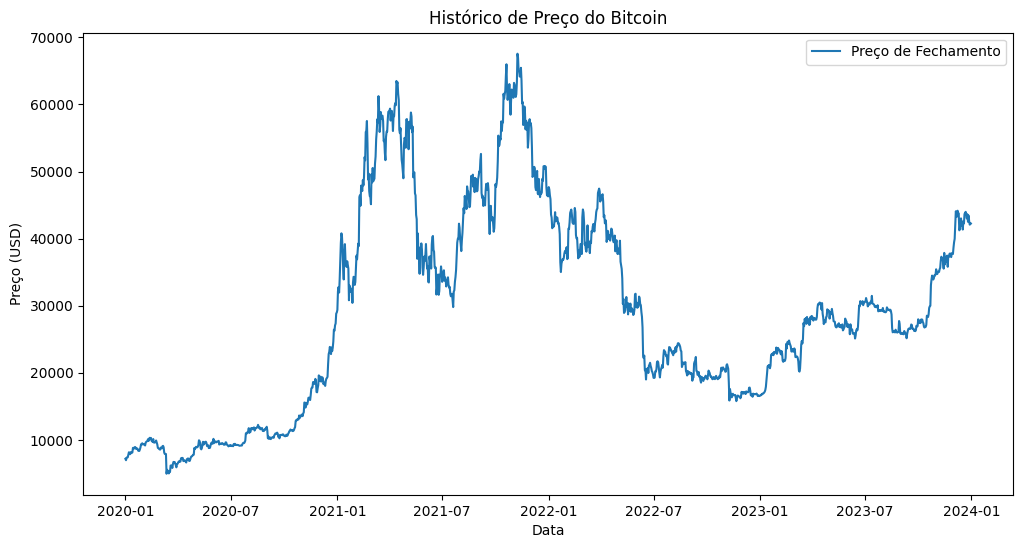

In [ ]:
# Baixando os dados do Bitcoin
df = yf.download('BTC-USD', start='2020-01-01', end='2024-01-01')

# Visualizando os primeiros dados
print(df.head())

# Plotando o histórico de preços
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Preço de Fechamento')
plt.title('Histórico de Preço do Bitcoin')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show

## 4. Preparação dos Dados
Precisamos estruturar os dados em janelas de tempo para que a LSTM possa aprender os padrões.

In [ ]:
# Normalizando os dados para o intervalo [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['Close']])

# Criando sequências de entrada e saída
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Definindo o tamanho da janela
seq_length = 50
X, y = create_sequences(df_scaled, seq_length)

# Ajustando o formato para entrada na LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


## 5. Construindo o Modelo LSTM

In [ ]:
# Construindo o modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compilando o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Sumário do modelo
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Treinando o Modelo

In [ ]:
# Treinamento do modelo
model.fit(X, y, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0345
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0022
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0017
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0014
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0014
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0013
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0013
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0010
Epoch 9/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 9.1261e-04
Epoch 10/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 9.5563e-04
Epoch 11/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 8.3412e-04
Epoch 12/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 8.2823e-04
Epoch 13/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 8.5428e-04
Epoch 14/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 7.1522e-04
Epoch 15/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms

## 7. Fazendo Previsões

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


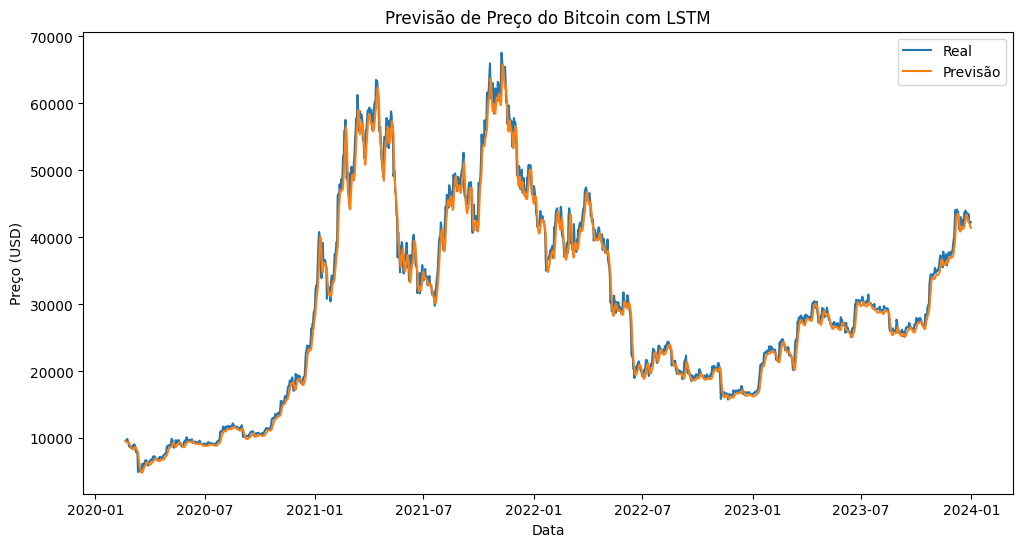

In [ ]:
# Fazendo previsões
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

# Plotando os resultados
plt.figure(figsize=(12,6))
plt.plot(df.index[seq_length:], scaler.inverse_transform(y.reshape(-1, 1)), label='Real')
plt.plot(df.index[seq_length:], predictions, label='Previsão')
plt.legend()
plt.title('Previsão de Preço do Bitcoin com LSTM')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.show()


## 8. Glossário de Termos - LSTM



- **Redes Neurais Recorrentes (RNN - Recurrent Neural Networks)**  
  Uma classe de redes neurais projetada para processar **dados sequenciais**, como séries temporais e texto. Ao contrário das redes feedforward, as RNNs possuem **memória** e podem armazenar informações de estados anteriores.

- **Problema do Desvanecimento do Gradiente**  
  Ocorre quando o gradiente da função de perda **diminui exponencialmente** ao retropropagar em redes muito profundas, dificultando o aprendizado de **dependências de longo prazo**.

- **LSTM (Long Short-Term Memory)**  
  Uma variação das **Redes Neurais Recorrentes (RNNs)** que resolve o problema do **desvanecimento do gradiente** usando um **mecanismo de portas** que regula o fluxo de informações ao longo do tempo.

- **Portas (Gates)**  
  Componentes internos de uma célula **LSTM** que controlam o fluxo de informações dentro da célula. São elas:  
  - **Porta de Esquecimento ($ f_t $)**: Decide quais informações do estado anterior serão descartadas.  
  - **Porta de Entrada ($ i_t $)**: Regula a adição de novas informações ao estado da célula.  
  - **Porta de Saída ($ o_t $)**: Controla quais informações serão usadas na saída da LSTM.  

- **Função Sigmoide ($ \sigma $)**  
  Uma função matemática que transforma qualquer valor real em um intervalo entre **0 e 1**, sendo útil para ativar as **portas da LSTM**. Sua fórmula é:  
  $$
  \sigma(x) = \frac{1}{1 + e^{-x}}
  $$

- **Função Tangente Hiperbólica (tanh)**  
  Uma função de ativação que transforma valores entre **-1 e 1**, permitindo a modelagem de sinais positivos e negativos. Sua fórmula é:  
  $$
  \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
  $$

- **Estado da Célula ($ C_t $)**  
  A memória da LSTM, que transporta informações ao longo do tempo, sendo regulada pelas portas de **entrada** e **esquecimento**.

- **Estado Oculto ($ h_t $)**  
  A saída da célula LSTM em um determinado instante $ t $, usada para fazer previsões ou passar informações para a próxima camada.

- **Backpropagation Through Time (BPTT)**  
  Uma adaptação do algoritmo **Backpropagation**, aplicada em redes recorrentes para calcular os gradientes em sequências temporais.

- **Normalização Min-Max**  
  Uma técnica de pré-processamento usada para **escalar os valores dos dados** para um intervalo entre 0 e 1, ajudando a estabilizar o treinamento das redes neurais.

- **TensorFlow/Keras**  
  Bibliotecas populares para **treinamento de redes neurais**, usadas para construir, treinar e avaliar modelos **LSTM**.

- **Batch Size**  
  Número de amostras processadas antes da atualização dos **pesos** durante o treinamento de uma rede neural.

- **Épocas (Epochs)**  
  Número de vezes que o modelo passa por todo o **conjunto de dados de treinamento**.